# Modelos de Mezclas Gausianas (GMM)

Los Modelos de Mezclas Gausianas (GMM) son un enfoque probabilístico para modelar datos que provienen de múltiples distribuciones gaussianas. Este marco proporciona un punto de partida para explorar modelos generativos más avanzados, como las Redes Generativas Adversariales (GANs) o los Autoencoders Variacionales (VAEs). En este contexto, los GMM son útiles no solo para agrupar datos (clustering) sino también para generar nuevas muestras al realizar muestreo a partir de las distribuciones ajustadas.

### Dataset
En este caso, utilizando el dataset FashionMNIST, que contiene imagenes  en escala de grises de 28x28 pixeles, asociadas con 10 clases de prendas de vestir. El dataset consiste en un conjunto de entrenamiento y de prueba de 60,000 y 10,000 ejemplos, respectivamente.


In [ ]:
#@title Inicializacion


# Importa los módulos
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import transforms, utils
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
from tqdm import tqdm


# Definicion de variables globales
BATCH_SIZE = 20    # Tamaño de lote
IMG_SIZE = 32       # Tamaño de la imagen
C_IN = 1            # Numero de canales de entrada

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

DEVICE

'cpu'

100%|██████████| 26.4M/26.4M [00:01<00:00, 19.1MB/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 302kB/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.50MB/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.18MB/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



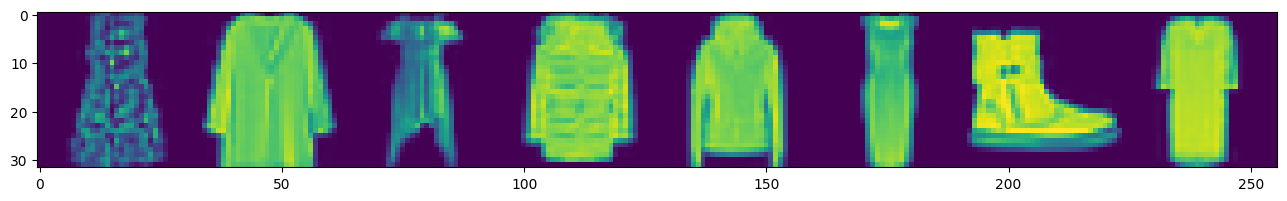

In [ ]:
#@title Carga y preprocesamiento de los datos

# Define una función para cargar y transformar los datos de entrada
def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),    # Cambia el tamaño de las imágenes
        transforms.RandomHorizontalFlip(),          # Aplica un volteo horizontal aleatorio a las imágenes, lo que ayuda a aumentar la variedad de datos para mejorar la generalización del modelo.
        transforms.ToTensor(),                      # Convierte las imagenes a tensores de PyTorch, escalando automáticamente los valores de píxeles a un rango [0, 1]
        transforms.Lambda(lambda t: (t * 2) - 1)    # Aplica una transformación para escalar los valores de los tensores de [0, 1] a [-1, 1]
    ]

    data_transform = transforms.Compose(data_transforms) # Combina las transformaciones definidas en data_transforms en un único objeto que se aplicará a las imágenes de forma secuencial.

    # Descarga el conjunto de datos de entrenamiento (train=True) de FashionMNIST (si no está disponible localmente) en el directorio actual (root="."), aplicando las transformaciones definidas.
    data = torchvision.datasets.FashionMNIST(root=".", download=True, train=True, transform=data_transform)
    return data

# Define una función para mostrar las imágenes
def plot_images(images, title=None):
    plt.figure(figsize=(16, 3))
    plt.imshow(torch.cat([
        torch.cat([i for i in images], dim=-1)
    ], dim=-2).permute(1, 2, 0).cpu())
    if title:
      plt.title(title)
    plt.show()


data = load_transformed_dataset()

# Crea un generador que itera sobre el conjunto de datos para particinarlos en lotes
dataloader = DataLoader(data,
                        batch_size=BATCH_SIZE, # Tamaño de cada lote
                        shuffle=True,          # Mezcla aleatoriamente los datos antes de iterarlos
                        drop_last=True         # Descarta el último lote si no tiene el tamaño completo
                        )
batch_x, batch_y = next(iter(dataloader))
plot_images(batch_x[:8])

 Ajustaremos un modelo de GMM con 10 componentes gaussianas, donde cada componente corresponde a una clase de prenda del conjunto de datos. Primero definimos el modelo.

In [ ]:
#@title Definicion del modelo

!git clone https://github.com/Enforcer03/GMM-generation.git
%cd GMM-generation

from gmm_model import GaussianMixture

# Initializar el GMM
n_components = 10 # Numero de Gaussianas == Numero de clases en el dataset
gmm = GaussianMixture(n_components=n_components, n_features=32 * 32, covariance_type="diag")

Cloning into 'GMM-generation'...
remote: Enumerating objects: 3296, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3296 (delta 0), reused 0 (delta 0), pack-reused 3293 (from 1)
Receiving objects: 100% (3296/3296), 59.85 MiB | 36.57 MiB/s, done.
/content/GMM-generation



Antes de entrenar el modelo de GMM, esteblezcamos un marco conceptual común que nos facilite, más adelante, trazar analogías con modelos generativos más complejos, en particular aquellos basados en Redes Neuronales profundas.<br><br>

### Funcion de log-verosimilitud
El objetivo es maximizar la función de **log-verosimilitud** del dataset, es decir, encontrar los parámetros del modelo como los pesos de cada componente gaussiana ($\pi_k$), las medias ($\mu_k$) y las matrices de covarianza ($\Sigma_k$), que mejor expliquen los datos observados.

De manera general, la función de log-verosimilitud $ \log p(\mathbf{X} | \theta) $ de un conjunto de datos $ \mathbf{X} = \{ \mathbf{x}_1, \mathbf{x}_2, ..., \mathbf{x}_N \}$ esta dada por:

$$
\log p(\mathbf{X} | \theta) = \sum_{i=1}^N \log p(\mathbf{x}_i | \boldsymbol{\theta}).
$$
<br><br>

### Variables latentes
Los GMM asumen que cada muestra $x_i$ es generada por una de las
$K$ componentes gaussianas, pero no sabemos cuál. Para modelar esta incertidumbre, introducimos una variable latente $z_i$, donde:

$$ z_i \in \{1, 2, \dots, K\} $$

indica la asignación de la muestra $x_i$ a la $k$-ésima componente. Usando esta variable latente, podemos expresar la probabilidad marginal de $ \mathbf{x}_i $ como una suma sobre todas las posibles configuraciones de $ z_i $:

$$
p(\mathbf{x}_i | \boldsymbol{\theta}) = \sum_{k=1}^K p(\mathbf{x}_i, z_i = k | \boldsymbol{\theta}),
$$

donde $ K $ es el número de componentes en la mezcla. Aplicando la regla de la cadena:

$$
p(\mathbf{x}_i, z_i = k | \boldsymbol{\theta}) =  p(\mathbf{x}_i | z_i = k, \boldsymbol{\theta}) \cdot  p(z_i = k),
$$

donde:

* $p(z_i = k)$ es la probabilidad *a priori* de la $k$-ésima componente, $\pi_k$ , y
* $ p(\mathbf{x}_i | z_i = k, \boldsymbol{\theta})$ es la densidad de probabilidad gaussiana de la $k$-ésima componente, $\mathcal{N}(x_i \mid \mu_k, \Sigma_k) $,  con media $\mu_k$ y covarianza $\Sigma_k$

Al sustituir en la log-verosimilitud:

$$\log p(X \mid \theta) = \sum_{i=1}^N \log \left( \sum_{k=1}^K \pi_k \, \mathcal{N}(x_i \mid \mu_k, \Sigma_k) \right)$$
<br><br>

### Evidence Lower Bound (ELBO)
Maximizar directamente esta función de log-verosimilitud es difícil debido a la suma dentro del logaritmo. Para superar esta dificultad, introducimos una distribución auxiliar $q(z_i)$, que representa una estimación de la distribución *a posteriori* $p(z_i | x_i, \mathbf{\theta}) $. Aplicando la desigualdad de Jensen, obtenemos un límite inferior para la log-verosimilitud:  

$$ \log p(X \mid \theta) \geq \sum_{i=1}^N \sum_{k=1}^K q(z_i = k) \log \left( \frac{\pi_k \, \mathcal{N}(x_i \mid \mu_k, \Sigma_k)}{q(z_i = k)} \right)
 $$

El término de la derecha se conoce como el Evidence Lower Bound (ELBO) y se denota con $ \mathcal{L}(\boldsymbol{\theta}, q)$
<br><br>

### ELBO y divergencia KL

Reescribiendo la log-verosimilitud como una combinación de ELBO y divergencia de Kullback-Leibler (KL):

$$\log p(X \mid \theta) = \mathcal{L}(\theta, q) + \sum_{i=1}^N \text{KL}(q(z_i) \mid\mid p(z_i \mid x_i, \theta)) $$

KL aparece como una medida de la discrepancia entre la distribución auxiliar $ q(z_i = k) $ y la verdadera distribución *a posteriori*  $ p(z_i = k | x_i, \boldsymbol{\theta})$ de que el dato $ x_i $  provenga del componente $ k $. Al maximizar el ELBO, reducimos la KL, lo que implica que $ q(z_i) $ se aproxima a $ p(z_i | x_i, \boldsymbol{\theta})$.

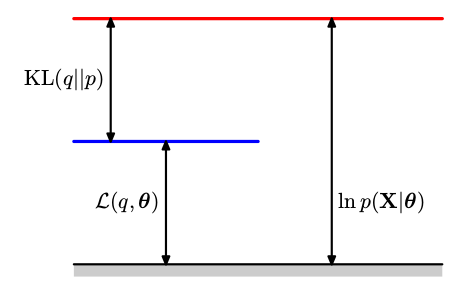

La ecuación del ELBO establece un marco conceptual común para entender como funcionan los modelos generativos más complejos, como los VAEs y los modelos difusivos.

In [ ]:
#@title Entrenamiento del modelo GMM

# Acumula todos los datos
all_data = []

for batch_idx, (data, target) in enumerate(dataloader):
    # Aplana las imágenes
    data = data.view(data.size(0), -1)  # Shape: (batch_size, 32*32)
    all_data.append(data)

# Concatenar todos los datos y ajustar el modelo
all_data = torch.cat(all_data, dim=0)  # Combina todos los lotes
gmm.fit(all_data)  # Ajusta el modelo GMM a los datos acumulados


Recordemos que nuestro objetivo al entrenar un GMM es maximizar $\mathcal{L}(\theta, q)$ o ELBO, de forma que se acerque lo más posible a la log-verosimilitud.

Al intentar maximizar $\mathcal{L}(\theta, q)$ nos encontramos con la dificulad de tener que optimizar simultáneamente dos conjuntos de variables, $q$ y $\mathbf{\theta}$, que son interdependientes entre si.

El algoritmo de Expectativa-Maximización (EM) aborda este problema de forma iterativa.
<br><br>


### Expectativa-Maximización (EM)

El algoritmo EM consiste en dos pasos sucesivos que se repiten:

**1. Paso E (Expectativa)**

En este paso, se aplica el **teorema de Bayes** para calcular las probabilidades *a posteriori* aproximadas $q(z_i = k)$ de que cada punto $x_i$ provenga de cada componente $k$, fijando los parámetros $\theta = \{\pi_k, \mu_k, \Sigma_k\}$:

$$
q(z_i = k) \approx  p(z_i = k \mid x_i, \theta) = \frac{\pi_k N(x_i \mid \mu_k, \Sigma_k)}{\sum_{j=1}^{K} \pi_j N(x_i \mid \mu_j, \Sigma_j)}.
$$

**2. Paso M (Maximización)**

En el paso M se usan los $q(z_i)$ obtenidas en el paso E, para actualizar los parámetros $\theta = \{\pi_k, \mu_k, \Sigma_k\}$.

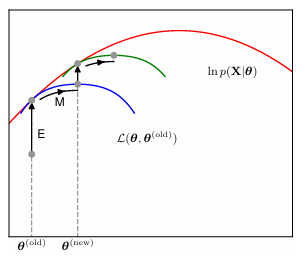

La siguiente figura muestra un ejemplo de aplicación del algoritmo de EM para identificar agrupamiento de datos empleando dos componentes gaussianas:

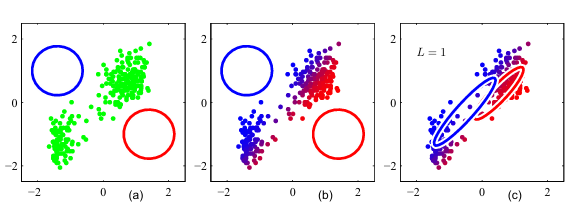

En (a) los puntos de datos están representados en verde junto con la configuración inicial del modelo de mezcla. Las elipses azul y roja muestran los contornos las dos componentes gaussianas, inicialmente definidas con $\mu$ aleatoria y $\Sigma=1$   

Tras el primer paso E (b), cada punto de datos está coloreado proporcionalmente con tinta azul o roja, según la probabilidad *a posteriori* de haber sido generado por el componente azul o rojo. Los puntos con probabilidades similares de pertenecer a ambos clusters aparecen morados.

Después del primer paso M (c), la media de la gaussiana azul se mueve hacia el centro de masa de los puntos ponderados por las probabilidades de pertenencia al cluster azul. De manera similar, la covarianza se ajusta según la distribución de los puntos en el "tinte azul". Lo mismo ocurre con el componente rojo.

El proceso se reitera iterativamente hasta convergencia.

# Generación de nuevas imagenes

Una vez entrenado el modelo GMM, podemos utilizarlo para generar nuevas imágenes de prendas de vestir. Definimos una distribución *a priori*
$p(z)$ sobre la variable latente, junto con una distribución condicional gaussiana $p(x|z)$ para la variable observada $x$ de D-dimensiones, condicionada al valor de la variable latente.

Como en nuestro caso, $z$ es una variable discreta que toma valores de $k=1-10$, correspondientes a las $K = 10$ clases de prendas de vestir, $p(z)$ es una distribucion multinomial. Realizamos un muestreo sobre las K componentes gaussianas, ponderadas segun sus pesos $\pi_k$:

$$z \sim Multinomial(\pi_1, \pi_2, ... \pi_K)$$

Supongamos que el muestreo arroja $z=9$, asociado a la categoria "bota" del FashionMNIST dataset.

A continuación, realizamos un muestreo sobre el espacio continuo asociado a dicha componente gaussiana con media $\mu_{(k=9)}$ y covarianza $\Sigma_{(k=9)} $, para obtener una nueva imagen $x_i$ de una bota, en la representación $D$-dimensional de la variable observada (ej. 28 x 28 pixeles):  

$$x_i \sim \mathcal{N}(\mu^{(k)}, \Sigma^{(k)})$$

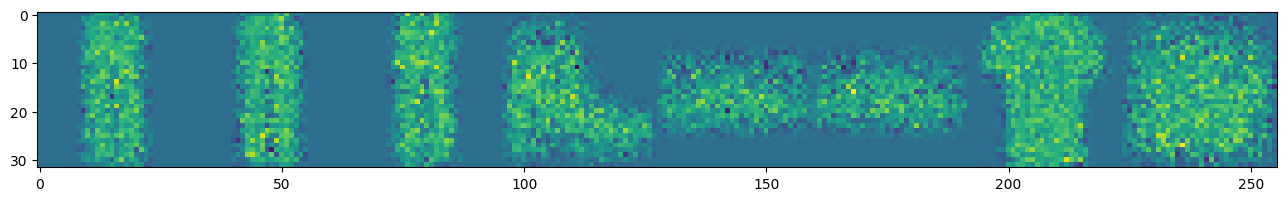

In [ ]:
#@title Generemos algunas imagenes

# Muestreamos la variable latente z para seleccionar la componente
n_samples= 8  # Definimos el numero de imagenes que queremos muestrear
counts = torch.distributions.multinomial.Multinomial(total_count=n_samples, probs=gmm.pi.squeeze()).sample()    # muestreamos entre las K componentes gaussianas según sus pesos

x = torch.empty(0, device=counts.device)  # Creamos un tensor vacío para almacenar las muestras generadas
y = torch.cat([torch.full([int(sample)], j, device=counts.device) for j, sample in enumerate(counts)])    # Creamos un tensor 'y' que contiene las etiquetas de cada muestra.

# Muestreamos sobre la componente seleccionada para generar una nueva imagen
for k in np.arange(gmm.n_components)[counts > 0]:    # Solo iterar sobre componentes con conteos no cero
  x_k = gmm.mu[0, k] + torch.randn(int(counts[k]), gmm.n_features, device=x.device) * torch.sqrt(gmm.var[0, k])
  x = torch.cat((x, x_k), dim=0)

# visualizamos las imagenes generadas
plot_images(x.view(n_samples, 1, 32, 32))


Vemos que las imagenes se ven borrosas y apenas podemos distiguir de que prenda se trata. Para obtener imágenes más nítidas y realistas, es necesario utilizar modelos más complejos como las redes neuronales profundas.

## **Preguntas y actividades:**

* ¿Cuáles considera que son las principales limitaciones del modelo de mezclas gaussianas para generar imágenes más nítidas?

* Investigue cómo influye la cantidad de componentes gaussianas en la calidad de las imágenes generadas.

* El modelo entrenado de mezclas gaussianas tiene la limitación de generar imágenes de cualquier tipo de prenda de vestir sin discriminar categorías específicas. ¿Cómo podría modificarlo para generar imágenes exclusivamente de un tipo particular de prenda que me interese? ¿Se animan a plantearlo en código?